# Results Inspection

In [ ]:
import pandas as pd
import glob
import os

pd.set_option('display.max_colwidth', 0)

In [ ]:
# origloss_NBTale = pd.read_csv("./logs/OrigLoss_V5/NBTale_results_wav2vec2_NO_origLossV5_2023-09-18.csv")
# origloss_NBTale.drop(columns=["Unnamed: 0", "wav_file", "path", "text"], inplace=True)
# origloss_NBTale.rename(columns={"asr_str": "asr_origloss", "wer":"wer_origloss", "asd":"asd_origloss"}, inplace=True)

In [ ]:
path = "./logs/OrigLoss_V5/"
all_files = glob.glob(os.path.join(path , "*.csv"))

origloss_dfs = []
for file in all_files:
    df = pd.read_csv(file)
    df.drop(columns=["Unnamed: 0", "wav_file", "path", "text"], inplace=True)
    df.rename(columns={"asr_str": "asr_origloss", "wer":"wer_origloss", "asd":"asd_origloss"}, inplace=True)
    origloss_dfs.append(df)

origloss = pd.concat(origloss_dfs, ignore_index=True)

In [ ]:
# customloss_NBTale = pd.read_csv("./logs/CustomLoss_V7/NBTale_results_wav2vec2_NO_customLossV7_2023-10-02.csv")
# customloss_NBTale.drop(columns=["Unnamed: 0", "wav_file", "path", "text", "segment_id"], inplace=True)
# customloss_NBTale.rename(columns={"asr_str": "asr_customloss", "wer":"wer_customloss", "asd":"asd_customloss"}, inplace=True)

In [ ]:
path = "./logs/CustomLoss_V7/"
all_files = glob.glob(os.path.join(path , "*.csv"))

customloss_dfs = []
for file in all_files:
    df = pd.read_csv(file)
    df.drop(columns=["Unnamed: 0", "wav_file", "path", "text", "segment_id"], inplace=True)
    df.rename(columns={"asr_str": "asr_customloss", "wer":"wer_customloss", "asd":"asd_customloss"}, inplace=True)
    customloss_dfs.append(df)

customloss = pd.concat(customloss_dfs, ignore_index=True)

### Merged results of orig loss & custom loss

In [ ]:
merged_results = pd.merge(origloss, customloss, on="ref_str")
merged_results = merged_results.reindex(columns=["segment_id", "ref_str", "asr_origloss", "wer_origloss", "asd_origloss", "asr_customloss", "wer_customloss", "asd_customloss"])

In [ ]:
better_wer = merged_results[merged_results["wer_origloss"] > merged_results["wer_customloss"]]
worse_wer = merged_results[merged_results["wer_origloss"] < merged_results["wer_customloss"]]
better_asd = merged_results[merged_results["asd_origloss"] > merged_results["asd_customloss"]]
worse_asd = merged_results[merged_results["asd_origloss"] < merged_results["asd_customloss"]]

### better WER but *worse* ASD when using custom loss

In [ ]:
better_wer[better_wer["asd_origloss"] < better_wer["asd_customloss"]]

### worse WER but *better* ASD when using custom loss

In [ ]:
worse_wer[worse_wer["asd_origloss"] > worse_wer["asd_customloss"]]

In [ ]:
wer_improved_percent = (len(better_wer)/len(merged_results)) * 100
asd_improved_percent = (len(better_asd)/len(merged_results)) * 100

wer_worsened_percent = (len(worse_wer)/len(merged_results)) * 100
asd_worsened_percent = (len(worse_asd)/len(merged_results)) * 100

In [ ]:
print(f"WER improved: {wer_improved_percent:.2f}%")
print(f"ASD improved: {asd_improved_percent:.2f}%")

print(f"WER worsened: {wer_worsened_percent:.2f}%")
print(f"ASD worsened: {asd_worsened_percent:.2f}%")

# CTC LOSS IMPLEMENTATION

In [3]:
import collections
if not hasattr(collections, "Container"):
    import collections.abc
    collections.Container = collections.abc.Container
import transformers
from transformers import AutoTokenizer, BertModel
from transformers import Wav2Vec2CTCTokenizer, Wav2Vec2FeatureExtractor, Wav2Vec2Processor
from transformers import Wav2Vec2ForCTC, Wav2Vec2ProcessorWithLM, TrainingArguments, Trainer
from datasets import load_dataset, load_metric, ClassLabel, Audio, Dataset
import random
import pandas as pd
import math
import numpy as np
import librosa
import os
import torch
from pydub import AudioSegment
from IPython.display import display, HTML
import re
import json
from dataclasses import dataclass, field
from typing import Any, Dict, List, Optional, Union
import wandb
import argparse
import types
from tabulate import tabulate
from dtw import *
import torch
from scipy.spatial import distance
import copy
import pickle
from tqdm import tqdm

/tmp/ipykernel_545982/4039199176.py:2: DeprecationWarning: Using or importing the ABCs from 'collections' instead of from 'collections.abc' is deprecated since Python 3.3, and in 3.10 it will stop working
  if not hasattr(collections, "Container"):
/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



## Data Prep

In [4]:
chars_to_ignore_regex = '[\,\?\.\!\-\;\:\"\*]'
def remove_special_characters(batch):
    batch["text"] = re.sub(chars_to_ignore_regex, '', batch["text"]).lower()
    return batch

def prepare_dataset(batch):
    audio = batch["audio"]
    # batched output is "un-batched" to ensure mapping is correct
    batch["input_values"] = processor(audio["array"], sampling_rate=audio["sampling_rate"]).input_values[0]
    with processor.as_target_processor():
        batch["labels"] = processor(batch["text"]).input_ids
    return batch

In [5]:
model_name = "NbAiLab/nb-wav2vec2-300m-bokmaal"

processor = Wav2Vec2ProcessorWithLM.from_pretrained(model_name)
processor_woLM = Wav2Vec2Processor.from_pretrained(model_name)

# model = Wav2Vec2ForCTC.from_pretrained(model_name)
model = Wav2Vec2ForCTC.from_pretrained(
    model_name,
    ctc_loss_reduction="mean",
    pad_token_id=processor.tokenizer.pad_token_id,
)
model_tokenizer = AutoTokenizer.from_pretrained(model_name)

/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/huggingface_hub/utils/_deprecation.py:97: FutureWarning: Deprecated argument(s) used in 'snapshot_download': allow_regex. Will not be supported from version '0.12'.

Please use `allow_patterns` and `ignore_patterns` instead.
  warnings.warn(message, FutureWarning)
Fetching 4 files: 100%|██████████| 4/4 [00:00<00:00, 950.44it/s]


In [ ]:
# sum(p.numel() for p in model.parameters() if p.requires_grad)

In [6]:
df_train = pd.read_csv("../../model_ckpts/fine-tuning_wav2vec2_origLossTRIAL20_titan1/runs/train_set.csv")
df_train.drop(columns=["Unnamed: 0"], inplace=True)
train_dataset = Dataset.from_pandas(df_train)
train_dataset = train_dataset.cast_column("path", Audio())
train_dataset = train_dataset.rename_column("path", "audio")
train_dataset = train_dataset.cast_column("audio", Audio(sampling_rate=16_000))
train_dataset = train_dataset.map(prepare_dataset, remove_columns=train_dataset.column_names, num_proc=4)

#0:   0%|          | 0/5468 [00:00<?, ?ex/s]/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/transformers/models/wav2vec2_with_lm/processing_wav2vec2_with_lm.py:584: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(
/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/transformers/models/wav2vec2_with_lm/processing_wav2vec2_with_lm.py:584: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(

#0:   0%|          | 4/5468 [00:00<02:18, 39.33ex/s]/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/transformers/model

In [7]:
# input_feature = [{"input_values": train_dataset[2]["input_values"]}]
# label_feature = [{"input_ids": train_dataset[2]["labels"]}]

input_feature = [{"input_values": input_values} for input_values in train_dataset[34:41]["input_values"]]
label_feature = [{"input_ids": labels} for labels in train_dataset[34:41]["labels"]]

batch = processor.pad(input_feature, padding=True, return_tensors="pt")

with processor.as_target_processor():
    label = processor.pad(label_feature, padding=True, return_tensors="pt")
label = label["input_ids"].masked_fill(label.attention_mask.ne(1), -100)

batch["labels"] = label

/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/site-packages/transformers/models/wav2vec2_with_lm/processing_wav2vec2_with_lm.py:584: UserWarning: `as_target_processor` is deprecated and will be removed in v5 of Transformers. You can process your labels by using the argument `text` of the regular `__call__` method (either in the same call as your audio inputs, or in a separate call.
  warnings.warn(


In [ ]:
labels = batch["labels"][0]
labels_mask = labels >= 0
flattened_targets = labels.masked_select(labels_mask)
labels

In [ ]:
flattened_targets

## Investigating aligned cosdist (1 batch, size=8)

In [6]:
# LOADING THE MODEL FOR ASD METRIC
modelname = 'ltg/norbert2'
asd_model = BertModel.from_pretrained(modelname)
asd_tokenizer = AutoTokenizer.from_pretrained(modelname)

Some weights of the model checkpoint at ltg/norbert2 were not used when initializing BertModel: ['cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.dense.weight']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [7]:
# returning ASD cosdist alignment to reference tokens
def get_asd_align(ref, hyp, asd_model, asd_tokenizer):
    tokenized_ref = asd_tokenizer(ref, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = asd_tokenizer(hyp, padding=True, truncation=True, max_length=512, return_tensors="pt")
    ref_input_ids = tokenized_ref["input_ids"].squeeze()

    with torch.no_grad():
        model_output_ref = asd_model(**tokenized_ref, output_hidden_states=True)
        model_output_hyp = asd_model(**tokenized_hyp, output_hidden_states=True)
    hidden_states_ref = model_output_ref.hidden_states
    hidden_states_hyp = model_output_hyp.hidden_states
    all_layers_reference = []
    all_layers_hypothesis = []
    for i in range(1,13):
        all_layers_reference.append(hidden_states_ref[i].squeeze())
        all_layers_hypothesis.append(hidden_states_hyp[i].squeeze())
    ref_embedding_sequence = torch.stack(all_layers_reference).mean(dim=0)
    hyp_embedding_sequence = torch.stack(all_layers_hypothesis).mean(dim=0)

    alignment = dtw(hyp_embedding_sequence, ref_embedding_sequence, dist_method=distance.cosine, keep_internals=True)

    ref_alignment_idxs = alignment.index2
    hyp_alignment_idxs = alignment.index1

    ref_alignments = []
    for i in range(len(ref_alignment_idxs)):
        ref_embedding = ref_embedding_sequence[ref_alignment_idxs[i]]
        hyp_embedding = hyp_embedding_sequence[hyp_alignment_idxs[i]]
        cosdist = distance.cosine(ref_embedding, hyp_embedding)
        ref_token = asd_tokenizer.convert_ids_to_tokens(ref_input_ids[ref_alignment_idxs[i]].reshape(1))[0]
        ref_alignments.append((ref_alignment_idxs[i], ref_token, cosdist))

    return ref_alignments


def get_per_token_cosdist(asd_alignments):
    # collapse repetitions in tokens and wordpieces in the HYP alignment from ASD
    clean_alignment = []
    for i, item in enumerate(asd_alignments):
        if i < (len(asd_alignments) - 1):
            if len(clean_alignment) == 0:
                if item[1] != "[CLS]" and item[1] != "[SEP]":
                    clean_alignment.append(item)
            else:
                if item[0] == clean_alignment[-1][0]:
                    averaged_cosdist = sum([item[2], clean_alignment[-1][2]]) / 2
                    clean_alignment.pop(-1)
                    clean_alignment.append((item[0], item[1], averaged_cosdist))
                else:
                    clean_alignment.append(item)

    # GROUPING THE TOKENS FROM ASD CALCULATION, SUCH THAT WORDPIECES ARE TOGETHER
    regrouped_tokens = []
    for i, item in enumerate(clean_alignment):
        if item[1] != "[CLS]" and item[1] != "[SEP]":
            if "##" not in item[1]:
                if i < (len(clean_alignment)-1) and "##" in clean_alignment[i+1][1]:  # start of a group of wordpieces
                    wordpiece_group = []
                    wordpiece_group.append(item)
                    regrouped_tokens.append(wordpiece_group)
                else:
                    regrouped_tokens.append(item)
            elif "##" in item[1]:  # parts of the word
                wordpiece_group.append(item)

    # COLLAPSE WORDPIECES INTO WORDS & TAKE AVERAGE OF COSDIST
    tokens_compressed = []
    for token_group in regrouped_tokens:
        if isinstance(token_group, list):
            wp_combined = ''.join([wordpiece[1].replace("##", "") for wordpiece in token_group])
            token_ave_cosdist = sum([wordpiece[2] for wordpiece in token_group]) / len(token_group)
            tokens_compressed.append(("combined", wp_combined, token_ave_cosdist))
        else:
            tokens_compressed.append(token_group)

    return tokens_compressed


# aligning ASD cosdist values to label sequence
def get_cosdist_for_ctc(tokens_compressed, label_ids):
    cosdist_for_ctc = []
    token_count = 0
    for i, label in enumerate(label_ids):
        # for the first utterance
        if len(cosdist_for_ctc) == 0 or all(cosdist == 0 for cosdist in cosdist_for_ctc):
            if label == 0 or label > 29:
                cosdist_for_ctc.append(0)
            else:
                if tokens_compressed[token_count][2] == 0:
                    print("OH NOOO", tokens_compressed[token_count][2])
                cosdist_for_ctc.append(tokens_compressed[token_count][2])
        # for the next utterances
        else:
            if label == 0:
                cosdist_for_ctc.append(0)
                if i < (len(label_ids)-1) and 0 < label_ids[i+1] < 30:
                    token_count += 1
            else:
                if tokens_compressed[token_count][2] == 0:
                    print("OH NOOO", tokens_compressed[token_count][2])
                cosdist_for_ctc.append(tokens_compressed[token_count][2])
    return cosdist_for_ctc

In [8]:
cosdist_register = []

for i in tqdm(range(100)):
    input_feature = [{"input_values": input_values} for input_values in train_dataset[i*8:(i+1)*8]["input_values"]]
    label_feature = [{"input_ids": labels} for labels in train_dataset[i*8:(i+1)*8]["labels"]]

    batch = processor.pad(input_feature, padding=True, return_tensors="pt")

    with processor.as_target_processor():
        label = processor.pad(label_feature, padding=True, return_tensors="pt")
    label = label["input_ids"].masked_fill(label.attention_mask.ne(1), -100)

    batch["labels"] = label

    output = model(**batch)
    output_logits = output["logits"]
    pred_str = processor.batch_decode(output_logits.detach().numpy()).text

    labels = batch["labels"]
    labels_str = processor_woLM.batch_decode(labels, group_tokens=False)

    for i in range(len(pred_str)):
        ref_text = labels_str[i].replace("[UNK]", "")
        pred_text = pred_str[i].replace("[UNK]", "")
        label_ids = labels[i]
        labels_mask = label_ids >= 0
        flattened_labels = label_ids.masked_select(labels_mask)
        ref_alignments = get_asd_align(ref_text, pred_text, asd_model, asd_tokenizer)
        tokens_compressed = get_per_token_cosdist(ref_alignments)
        cosdist_for_ctc = get_cosdist_for_ctc(tokens_compressed, flattened_labels)
        cosdist_register.append(cosdist_for_ctc)


  0%|          | 0/100 [00:00<?, ?it/s]

OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0


  1%|          | 1/100 [00:23<39:17, 23.81s/it]

OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0
OH NOOO 0


Exception ignored in: <function _releaseLock at 0x7f6442423670>
Traceback (most recent call last):
  File "/home/janinelr/micromamba/envs/wav2vec/lib/python3.9/logging/__init__.py", line 227, in _releaseLock
    def _releaseLock():
KeyboardInterrupt: 


In [12]:
cosdist_register_arr = np.asarray(cosdist_register)

/tmp/ipykernel_976418/112888293.py:1: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  cosdist_register_arr = np.asarray(cosdist_register)


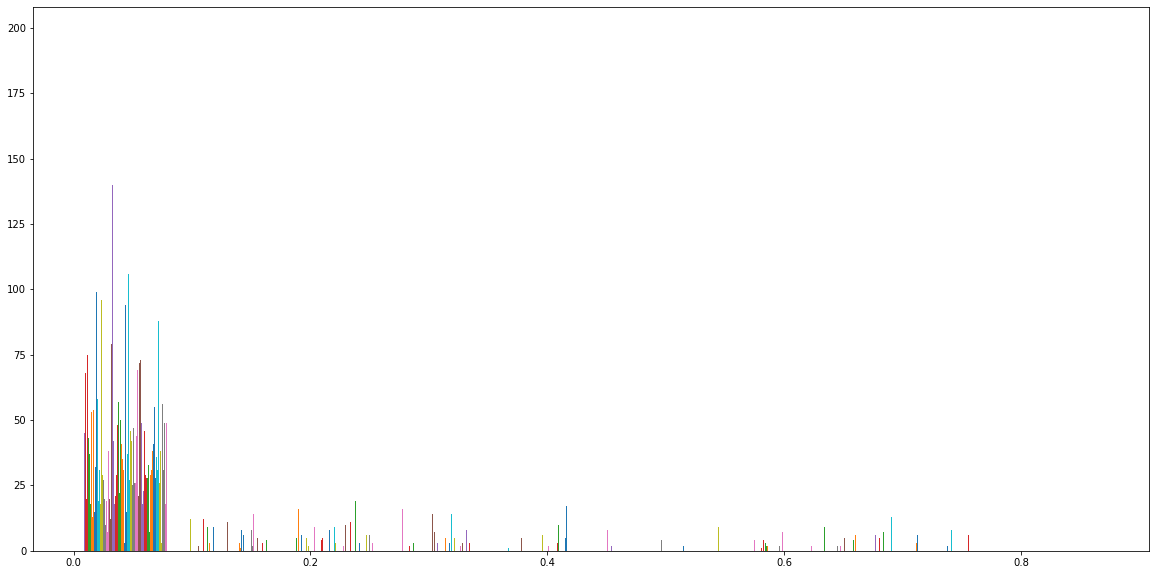

In [16]:
import matplotlib.pyplot as plt

plt.figure(figsize=(20,10))
plt.hist(cosdist_register_arr.flatten())
plt.show()

## Stanford CTC LOSS

In [ ]:
def ctc_loss(params, seq, blank=0):
    seqLen = seq.shape[0]  # length of label sequence
    numphones = params.shape[0]  # number of labels, not even used in the code
    L = 2*seqLen + 1  # length of the label sequence with blanks
    T = params.shape[1]  # length of utterance (time)

    # print(seqLen, numphones, L, T)

    alphas = np.zeros((L,T))
    betas = np.zeros((L,T))

    # convert logits to log softmax
    params = params - np.max(params,axis=0)
    params = np.exp(params)
    params = params / np.sum(params,axis=0)

    # initialize alphas and forward pass
    alphas[0,0] = params[blank,0]
    alphas[1,0] = params[seq[0],0]
    c = np.sum(alphas[:,0])
    alphas[:,0] = alphas[:,0] / c
    llForward = np.log(c)

    for t in range(1,T):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(start,L):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s==0:
                    alphas[s,t] = alphas[s,t-1] * params[blank,t]
                else:
                    alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[blank,t]
            # same label twice
            elif s == 1 or seq[l] == seq[l-1]:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[seq[l],t]
            else:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1] + alphas[s-2,t-1]) * params[seq[l],t]

        # normalize at current time (prevent underflow)
        c = np.sum(alphas[start:end,t])
        alphas[start:end,t] = alphas[start:end,t] / c
        llForward += np.log(c)

    # initialize betas and backwards pass
    betas[-1,-1] = params[blank,-1]
    betas[-2,-1] = params[seq[-1],-1]
    c = np.sum(betas[:,-1])
    betas[:,-1] = betas[:,-1] / c
    llBackward = np.log(c)

    for t in range(T-2,-1,-1):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(end-1,-1,-1):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s == L-1:
                    betas[s,t] = betas[s,t+1] * params[blank,t]
                else:
                    betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[blank,t]
            # same label twice
            elif s == L-2 or seq[l] == seq[l+1]:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[seq[l],t]
            else:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1] + betas[s+2,t+1]) * params[seq[l],t]

        # normalize at current time
        c = np.sum(betas[start:end,t])
        betas[start:end,t] = betas[start:end,t] / c
        llBackward += np.log(c)

    # Compute gradient with respect to unnormalized input parameters
    grad = np.zeros(params.shape)
    ab = alphas*betas
    for s in range(L):
        l = int((s-1)/2)
        # blank
        if s%2 == 0:
            grad[blank,:] += ab[s,:]
            ab[s,:] = ab[s,:]/params[blank,:]
        else:
            grad[seq[l],:] += ab[s,:]
            ab[s,:] = ab[s,:]/(params[seq[l],:])
    absum = np.sum(ab,axis=0)

    # Check for underflow or zeros in denominator of gradient
    llDiff = np.abs(llForward-llBackward)
    if llDiff > 1e-5 or np.sum(absum==0) > 0:
        print("Diff in forward/backward LL : %f"%llDiff)
        print("Zeros found : (%d/%d)"%(np.sum(absum==0),absum.shape[0]))
        # print(-llForward, grad)
        return (-llForward, grad)
    else:
        grad = params - grad / (params * absum)
        # print(-llForward, grad)
        return (-llForward, grad)

In [17]:
def ctc_loss_tensor(logits, seq, blank=0):
    params = logits.transpose(1,0)

    seqLen = seq.shape[0]  # length of label sequence
    L = 2*seqLen + 1  # length of the label sequence with blanks
    T = params.shape[1]  # length of utterance (time)
    numphones = params.shape[0]  # number of labels/characters in "alphabet"

    print("label seq:", seqLen)
    print("label seq length with blanks:", L)
    print("utterance length:", T)

    alphas = torch.zeros((L,T))
    betas = torch.zeros((L,T))

    # convert logits to log probs
    params = params - (torch.max(params, dim=0)[0])
    params = torch.exp(params)
    params = params / torch.sum(params, dim=0)

    # initialize alphas and forward pass
    alphas[0,0] = params[blank,0]
    alphas[1,0] = params[seq[0],0]
    c = torch.sum(alphas[:,0])
    alphas[:,0] = alphas[:,0] / c
    llForward = torch.log(c)

    for t in range(1,T):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(start,L):
            l = int((s-1)/2)
            print(0, L-2*(T-t), "time:", t, "start:", start, "L:", L, "s:", s, "l:", l)
            # blank
            if s%2 == 0:
                if s==0:
                    alphas[s,t] = alphas[s,t-1] * params[blank,t]
                else:
                    alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[blank,t]
            # same label twice
            elif s == 1 or seq[l] == seq[l-1]:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[seq[l],t]
            else:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1] + alphas[s-2,t-1]) * params[seq[l],t]

        # normalize at current time (prevent underflow)
        c = torch.sum(alphas[start:end,t])
        alphas[start:end,t] = alphas[start:end,t] / c
        llForward = llForward + torch.log(c)

    # initialize betas and backwards pass
    betas[-1,-1] = params[blank,-1]
    betas[-2,-1] = params[seq[-1],-1]
    c = torch.sum(betas[:,-1])
    betas[:,-1] = betas[:,-1] / c
    llBackward = torch.log(c)

    for t in range(T-2,-1,-1):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(end-1,-1,-1):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s == L-1:
                    betas[s,t] = betas[s,t+1] * params[blank,t]
                else:
                    betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[blank,t]
            # same label twice
            elif s == L-2 or seq[l] == seq[l+1]:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[seq[l],t]
            else:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1] + betas[s+2,t+1]) * params[seq[l],t]

        # normalize at current time
        c = torch.sum(betas[start:end,t])
        betas[start:end,t] = betas[start:end,t] / c
        llBackward = llBackward + torch.log(c)

    # Compute gradient with respect to unnormalized input parameters
    grad = torch.zeros(params.shape)
    ab = alphas*betas
    for s in range(L):
        l = int((s-1)/2)
        # blank
        if s%2 == 0:
            grad[blank,:] = grad[blank,:] + ab[s,:]
            ab[s,:] = ab[s,:]/params[blank,:]
        else:
            grad[seq[l],:] = grad[seq[l],:] + ab[s,:]
            ab[s,:] = ab[s,:]/(params[seq[l],:])
    absum = torch.sum(ab,axis=0)

    # Check for underflow or zeros in denominator of gradient
    # llDiff = torch.abs(llForward-llBackward)
    # if llDiff > 1e-5 or torch.sum(absum==0) > 0:
    #     print("Diff in forward/backward LL : %f"%llDiff)
    #     print("Zeros found : (%d/%d)"%(torch.sum(absum==0),absum.shape[0]))
    #     return (-llForward, grad)
    # else:
    #     grad = params - grad / (params * absum)
    #     return (-llForward, grad)

    for t in range(T):
        for s in range(numphones):
            tmp = (params[s,t]*absum[t])
            if tmp > 0:
                grad[s,t] = params[s,t] - grad[s,t] / tmp
            else:
                grad[s,t] = params[s,t]

    return (-llForward, grad)

In [8]:
def ctc_loss_newgrad(logits, seq, blank=0):
    params = logits.transpose(1,0)

    seqLen = seq.shape[0]  # length of label sequence
    L = 2*seqLen + 1  # length of the label sequence with blanks
    T = params.shape[1]  # length of utterance (time)
    numphones = params.shape[0]  # number of labels/characters in "alphabet"

    alphas = torch.zeros((L,T))
    betas = torch.zeros((L,T))

    # convert logits to log probs
    params = params - (torch.max(params, dim=0)[0])
    params = torch.exp(params)
    params = params / torch.sum(params, dim=0)

    # initialize alphas and forward pass
    alphas[0,0] = params[blank,0]
    alphas[1,0] = params[seq[0],0]
    c = torch.sum(alphas[:,0])
    alphas[:,0] = alphas[:,0] / c
    llForward = torch.log(c)

    for t in range(1,T):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(start,L):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s==0:
                    alphas[s,t] = alphas[s,t-1] * params[blank,t]
                else:
                    alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[blank,t]
            # same label twice
            elif s == 1 or seq[l] == seq[l-1]:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[seq[l],t]
            else:
                alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1] + alphas[s-2,t-1]) * params[seq[l],t]

        # normalize at current time (prevent underflow)
        c = torch.sum(alphas[start:end,t])
        alphas[start:end,t] = alphas[start:end,t] / c
        llForward = llForward + torch.log(c)

    # initialize betas and backwards pass
    betas[-1,-1] = params[blank,-1]
    betas[-2,-1] = params[seq[-1],-1]
    c = torch.sum(betas[:,-1])
    betas[:,-1] = betas[:,-1] / c
    llBackward = torch.log(c)

    for t in range(T-2,-1,-1):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(end-1,-1,-1):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s == L-1:
                    betas[s,t] = betas[s,t+1] * params[blank,t]
                else:
                    betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[blank,t]
            # same label twice
            elif s == L-2 or seq[l] == seq[l+1]:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[seq[l],t]
            else:
                betas[s,t] = (betas[s,t+1] + betas[s+1,t+1] + betas[s+2,t+1]) * params[seq[l],t]

        # normalize at current time
        c = torch.sum(betas[start:end,t])
        betas[start:end,t] = betas[start:end,t] / c
        llBackward = llBackward + torch.log(c)

    # Compute gradient according to https://github.com/yehudabab/NumpyCTC/blob/main/ctc.py
    padded_labels = torch.zeros((L))

    j = 0
    for i in range(L):
        if i%2 == 0:
            padded_labels[i] = 0
        else:
            padded_labels[i] = seq[j]
            j += 1

    # print(len(seq), seq)
    # print(len(padded_labels), padded_labels)

    grad = torch.zeros(params.shape)

    score_last = alphas[L-1, T-1]
    score_before_last = betas[L-2, T-1]
    p_l_given_ctc = score_last + score_before_last

    for t in range(T):
        for k in range(numphones):
            d_p_d_ytk = 0
            lb_lk = np.nonzero(list(map(lambda x: 1 if k in x else 0, padded_labels)))[0]
            for s in lb_lk:
                d_p_d_ytk += alphas[s, t] * betas[s, t]

            d_p_d_ytk /= (params[k, t] ** 2)
            d_lnp_d_ytk = (1. / p_l_given_ctc) * d_p_d_ytk
            grad[k, t] = d_lnp_d_ytk

    return (-llForward, grad)

## Trying out Stanford CTC Loss script

### Just 1 example

In [19]:
output = model(**batch)

In [ ]:
output

In [ ]:
logits = output["logits"][0].detach().cpu().numpy().transpose()
seq = batch["labels"][0].detach().cpu().numpy()

loss, grad = ctc_loss(logits, seq.squeeze(), blank=0)
print(loss)

In [ ]:
token_ids = torch.argmax(output["logits"][0], dim=1)
print(token_ids)
for token in token_ids:
    if token == 33:
        print("HUY")

decoded_tokens = []
for token in token_ids:
    decoded_tokens.append(model_tokenizer.decode(token))
print(decoded_tokens)

In [ ]:
import torch.nn.functional as F

logits = output["logits"][0]
log_probs = F.log_softmax(logits, dim=-1, dtype=torch.float32)
targets = batch["labels"][0]
input_lengths = torch.tensor(output["logits"][0].shape[0])
target_lengths = torch.tensor(batch["labels"][0].shape[0])

loss = F.ctc_loss(log_probs=log_probs, targets=targets, input_lengths=input_lengths, target_lengths=target_lengths, reduction="sum")
print(loss)

In [ ]:
logits = output["logits"][0].transpose(1,0)
seq = batch["labels"][0]

loss, grad = ctc_loss_tensor(logits, seq, blank=0)
print(loss)

In [ ]:
set(token_ids.tolist())

In [ ]:
print(grad.shape)
transposed_grad = grad.transpose(1,0)
print(transposed_grad.shape)

In [ ]:
for i in range(34):
    print(i, model_tokenizer.decode(i))

In [ ]:
for i in range(grad.shape[0]):
    print(i, grad[i])

In [ ]:
seq

### batched input

In [9]:
output = model(**batch)
output_logits = output["logits"]
labels = batch["labels"]

In [18]:
grad_to_inspect = []

for i, logits in enumerate(output_logits):
    label_ids = labels[i]
    labels_mask = label_ids >= 0
    flattened_labels = label_ids.masked_select(labels_mask)
    loss, grad = ctc_loss_tensor(logits, flattened_labels)
    grad_to_inspect.append(grad)
    print(logits.shape, loss)
    break

label seq: 61
label seq length with blanks: 123
utterance length: 323
0 -521 time: 1 start: 0 L: 123 s: 0 l: 0
0 -521 time: 1 start: 0 L: 123 s: 1 l: 0
0 -521 time: 1 start: 0 L: 123 s: 2 l: 0
0 -521 time: 1 start: 0 L: 123 s: 3 l: 1
0 -521 time: 1 start: 0 L: 123 s: 4 l: 1
0 -521 time: 1 start: 0 L: 123 s: 5 l: 2
0 -521 time: 1 start: 0 L: 123 s: 6 l: 2
0 -521 time: 1 start: 0 L: 123 s: 7 l: 3
0 -521 time: 1 start: 0 L: 123 s: 8 l: 3
0 -521 time: 1 start: 0 L: 123 s: 9 l: 4
0 -521 time: 1 start: 0 L: 123 s: 10 l: 4
0 -521 time: 1 start: 0 L: 123 s: 11 l: 5
0 -521 time: 1 start: 0 L: 123 s: 12 l: 5
0 -521 time: 1 start: 0 L: 123 s: 13 l: 6
0 -521 time: 1 start: 0 L: 123 s: 14 l: 6
0 -521 time: 1 start: 0 L: 123 s: 15 l: 7
0 -521 time: 1 start: 0 L: 123 s: 16 l: 7
0 -521 time: 1 start: 0 L: 123 s: 17 l: 8
0 -521 time: 1 start: 0 L: 123 s: 18 l: 8
0 -521 time: 1 start: 0 L: 123 s: 19 l: 9
0 -521 time: 1 start: 0 L: 123 s: 20 l: 9
0 -521 time: 1 start: 0 L: 123 s: 21 l: 10
0 -521 time: 1 

In [ ]:
for logits in output_logits:
    token_ids = torch.argmax(logits, dim=1)
    print(token_ids)

    decoded_tokens = []
    for token in token_ids:
        decoded_tokens.append(model_tokenizer.decode(token))
    print(decoded_tokens)

In [10]:
# comparing only the first utterance
model.train()
output = model(**batch)
output_logits = output["logits"]
labels = batch["labels"]

logits = output_logits[0]
label_ids = labels[0]
labels_mask = label_ids >= 0
flattened_labels = label_ids.masked_select(labels_mask)

In [11]:
logits.shape

torch.Size([235, 34])

In [13]:
# python-implemented CTC loss
loss, grad = ctc_loss_tensor(logits, flattened_labels)
print(loss)
print(grad.shape)

# for i, item in enumerate(grad):
#     print(i, item)

tensor(532.6441, grad_fn=<NegBackward0>)
torch.Size([34, 235])


In [14]:
loss, grad = ctc_loss_newgrad(logits, flattened_labels)
print(loss)
print(grad.shape)

# for i, item in enumerate(grad):
#     print(i, item)

tensor(532.6441, grad_fn=<NegBackward0>)
torch.Size([34, 235])


In [15]:
# pytorch CTC loss
import torch.nn.functional as F
log_probs = F.log_softmax(logits, dim=-1, dtype=torch.float32)
input_lengths = torch.tensor(logits.shape[0])
target_lengths = labels_mask.sum(-1)

loss = F.ctc_loss(log_probs=log_probs, targets=flattened_labels, input_lengths=input_lengths, target_lengths=target_lengths, reduction="sum")
print(loss)

# loss.backward()

# for name, param in model.named_parameters():
#     if param.requires_grad:
#         print(name, param.grad)
#         print(param.grad.shape)

tensor(532.6440, grad_fn=<SumBackward0>)


## Incorporating ASD into CTC Loss

### NOTE: start running here! (when loading from pickle)

In [ ]:
# NOV-8 DATA
# ref = "wozniackis drøm om seier knust av russiske jekaterina"
# hyp = "asnake drøm om sier knut av russiske karine"

# logit_frames_decoded = pickle.load(open("logit_frames_decoded_8Nov.pkl", "rb"))

# alignment_table = [logit_frames_decoded]
# table = tabulate(alignment_table, tablefmt="html")
# print("logits decoded")
# display(HTML(table))

### ASD metric

In [ ]:
# LOADING THE MODEL FOR ASD METRIC
modelname = 'ltg/norbert2'
asd_model = BertModel.from_pretrained(modelname)
asd_tokenizer = AutoTokenizer.from_pretrained(modelname)

In [ ]:
from numba import jit

In [ ]:
# returning ASD cosdist alignment to reference tokens

def get_asd_align(ref, hyp, asd_model, asd_tokenizer):
    tokenized_ref = asd_tokenizer(ref, padding=True, truncation=True, max_length=512, return_tensors="pt")
    tokenized_hyp = asd_tokenizer(hyp, padding=True, truncation=True, max_length=512, return_tensors="pt")
    ref_input_ids = tokenized_ref["input_ids"].squeeze()
    hyp_input_ids = tokenized_hyp["input_ids"].squeeze()

    with torch.no_grad():
        model_output_ref = asd_model(**tokenized_ref, output_hidden_states=True)
        model_output_hyp = asd_model(**tokenized_hyp, output_hidden_states=True)
    hidden_states_ref = model_output_ref.hidden_states
    hidden_states_hyp = model_output_hyp.hidden_states
    all_layers_reference = []
    all_layers_hypothesis = []
    for i in range(1,13):
        all_layers_reference.append(hidden_states_ref[i].squeeze())
        all_layers_hypothesis.append(hidden_states_hyp[i].squeeze())
    ref_embedding_sequence = torch.stack(all_layers_reference).mean(dim=0)
    hyp_embedding_sequence = torch.stack(all_layers_hypothesis).mean(dim=0)

    alignment = dtw(hyp_embedding_sequence, ref_embedding_sequence, dist_method=distance.cosine, keep_internals=True)
    num_tokens = len(ref_embedding_sequence)
    asd_score = (alignment.distance / num_tokens)

    ref_alignment_idxs = alignment.index2
    hyp_alignment_idxs = alignment.index1

    cosdist_alignment_tokens = []  # FOR PRINTING
    ref_alignments = []
    # hyp_alignments = []
    for i in range(len(ref_alignment_idxs)):
        ref_embedding = ref_embedding_sequence[ref_alignment_idxs[i]]
        hyp_embedding = hyp_embedding_sequence[hyp_alignment_idxs[i]]
        cosdist = distance.cosine(ref_embedding, hyp_embedding)
        cosdist_alignment_tokens.append(round(cosdist, 3))  # FOR PRINTING
        ref_token = asd_tokenizer.convert_ids_to_tokens(ref_input_ids[ref_alignment_idxs[i]].reshape(1))[0]
        # hyp_token = asd_tokenizer.convert_ids_to_tokens(hyp_input_ids[hyp_alignment_idxs[i]].reshape(1))[0]
        ref_alignments.append((ref_alignment_idxs[i], ref_token, cosdist))
        # hyp_alignments.append((hyp_alignment_idxs[i], hyp_token, cosdist))

    # FOR PRINTING
    # ref_alignment_input_ids = np.empty(len(ref_alignment_idxs), dtype=int)
    # for i, index in enumerate(ref_alignment_idxs):
    #     ref_alignment_input_ids[i] = (ref_input_ids[index])
    # ref_alignment_tokens = asd_tokenizer.convert_ids_to_tokens(torch.from_numpy(ref_alignment_input_ids))

    # hyp_alignment_input_ids = np.empty(len(hyp_alignment_idxs), dtype=int)
    # for i, index in enumerate(hyp_alignment_idxs):
    #     hyp_alignment_input_ids[i] = (hyp_input_ids[index])
    # hyp_alignment_tokens = asd_tokenizer.convert_ids_to_tokens(torch.from_numpy(hyp_alignment_input_ids))

    # hyp_alignment_tokens.insert(0, "HYP:")
    # ref_alignment_tokens.insert(0, "REF:")
    # cosdist_alignment_tokens.insert(0, "CosDist:")
    # alignment_table = [ref_alignment_tokens, hyp_alignment_tokens, cosdist_alignment_tokens]
    # table = tabulate(alignment_table, tablefmt="html")

    # print("Token alignment table:")
    # display(HTML(table))

    return ref_alignments

In [ ]:

def get_per_token_cosdist(asd_alignments):
    # collapse repetitions in tokens and wordpieces in the HYP alignment from ASD
    clean_alignment = []
    for i, item in enumerate(asd_alignments):
        if i < (len(asd_alignments) - 1):
            if len(clean_alignment) == 0:
                if item[1] != "[CLS]" and item[1] != "[SEP]":
                    clean_alignment.append(item)
            else:
                if item[0] == clean_alignment[-1][0]:
                    averaged_cosdist = sum([item[2], clean_alignment[-1][2]]) / 2
                    clean_alignment.pop(-1)
                    clean_alignment.append((item[0], item[1], averaged_cosdist))
                else:
                    clean_alignment.append(item)

    # GROUPING THE TOKENS FROM ASD CALCULATION, SUCH THAT WORDPIECES ARE TOGETHER
    regrouped_tokens = []
    for i, item in enumerate(clean_alignment):
        if item[1] != "[CLS]" and item[1] != "[SEP]":
            if "##" not in item[1]:
                if i < (len(clean_alignment)-1) and "##" in clean_alignment[i+1][1]:  # start of a group of wordpieces
                    wordpiece_group = []
                    wordpiece_group.append(item)
                    regrouped_tokens.append(wordpiece_group)
                else:  # not a start of wordpieces
                    regrouped_tokens.append(item)
            elif "##" in item[1]:  # parts of the word
                wordpiece_group.append(item)

    # COLLAPSE WORDPIECES INTO WORDS & TAKE AVERAGE OF COSDIST
    tokens_compressed = []
    for token_group in regrouped_tokens:
        if isinstance(token_group, list):
            wp_combined = ''.join([wordpiece[1].replace("##", "") for wordpiece in token_group])
            token_ave_cosdist = sum([wordpiece[2] for wordpiece in token_group]) / len(token_group)
            tokens_compressed.append(("combined", wp_combined, token_ave_cosdist))
        else:
            tokens_compressed.append(token_group)

    return tokens_compressed

In [ ]:
# aligning ASD cosdist values to label sequence

# def get_cosdist_for_ctc(tokens_compressed, label_ids):
#     cosdist_for_ctc = []
#     token_count = 0
#     for label in label_ids:
#         if label == 0:
#             token_count += 1
#             cosdist_for_ctc.append(0)
#         else:
#             cosdist_for_ctc.append(tokens_compressed[token_count][2])
#     if len(cosdist_for_ctc) != len(label_ids):
#         print("mismatch in number of tokens compressed and tokens identified from label ids")
#         return cosdist_for_ctc
#     else:
#         return cosdist_for_ctc

@jit(nopython=True)
def get_cosdist_for_ctc(tokens_compressed, label_ids):
    cosdist_for_ctc = []
    token_count = 0
    for i, label in enumerate(label_ids):
        # for the first utterance
        if len(cosdist_for_ctc) == 0 or all(cosdist == 0 for cosdist in cosdist_for_ctc):
            if label == 0 or label > 29:
                cosdist_for_ctc.append(0)
            else:
                cosdist_for_ctc.append(tokens_compressed[token_count][2])
        # for the next utterances
        else:
            if label == 0:
                cosdist_for_ctc.append(0)
                if i < (len(label_ids)-1) and label_ids[i+1] != 0:
                    token_count += 1
            else:
                cosdist_for_ctc.append(tokens_compressed[token_count][2])
    return cosdist_for_ctc

### Custom CTC with ASD

In [ ]:
# INCORPORATING ASD COSDIST VALUES TO THE CTC CALCULATION

def ctc_loss_with_ASD(params, seq, cosdist_for_ctc, blank=0):
    seqLen = seq.shape[0]  # length of label sequence
    L = 2*seqLen + 1  # length of the label sequence with blanks
    T = params.shape[1]  # length of utterance (time)

    alphas = torch.zeros((L,T))
    betas = torch.zeros((L,T))

    # convert logits to log probs
    params = params - (torch.max(params, dim=0)[0])
    params = torch.exp(params)
    params = params / torch.sum(params, dim=0)

    # initialize alphas and forward pass
    alphas[0,0] = params[blank,0]
    alphas[1,0] = params[seq[0],0]
    c = torch.sum(alphas[:,0])
    alphas[:,0] = alphas[:,0].clone() / c
    llForward = torch.log(c)

    for t in range(1,T):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(start,L):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s==0:
                    alphas[s,t] = alphas[s,t-1].clone() * params[blank,t]
                else:
                    alphas[s,t] = (alphas[s,t-1].clone() + alphas[s-1,t-1].clone()) * params[blank,t]
            # same label twice
            elif s == 1 or seq[l] == seq[l-1]:
                alphas[s,t] = (alphas[s,t-1].clone() + alphas[s-1,t-1].clone()) * params[seq[l],t] * (1 - cosdist_for_ctc[l])  # scale 0 to 1
            else:
                alphas[s,t] = (alphas[s,t-1].clone() + alphas[s-1,t-1].clone() + alphas[s-2,t-1].clone()) * params[seq[l],t] * (1 - cosdist_for_ctc[l])

        # normalize at current time (prevent underflow)
        c = torch.sum(alphas[start:end,t])
        alphas[start:end,t] = alphas[start:end,t].clone() / c
        llForward = llForward + torch.log(c)

    # initialize betas and backwards pass
    betas[-1,-1] = params[blank,-1]
    betas[-2,-1] = params[seq[-1],-1]
    c = torch.sum(betas[:,-1])
    betas[:,-1] = betas[:,-1].clone() / c
    llBackward = torch.log(c)

    for t in range(T-2,-1,-1):
        start = max(0,L-2*(T-t))
        end = min(2*t+2,L)
        for s in range(end-1,-1,-1):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                if s == L-1:
                    betas[s,t] = betas[s,t+1].clone() * params[blank,t]
                else:
                    betas[s,t] = (betas[s,t+1].clone() + betas[s+1,t+1].clone()) * params[blank,t]
            # same label twice
            elif s == L-2 or seq[l] == seq[l+1]:
                betas[s,t] = (betas[s,t+1].clone() + betas[s+1,t+1].clone()) * params[seq[l],t] * (1 - cosdist_for_ctc[l])
            else:
                betas[s,t] = (betas[s,t+1].clone() + betas[s+1,t+1].clone() + betas[s+2,t+1].clone()) * params[seq[l],t] * (1 - cosdist_for_ctc[l])

        # normalize at current time
        c = torch.sum(betas[start:end,t])
        betas[start:end,t] = betas[start:end,t].clone() / c
        llBackward = llBackward + torch.log(c)

    # Compute gradient with respect to unnormalized input parameters
    grad = torch.zeros(params.shape)
    ab = alphas*betas
    for s in range(L):
        l = int((s-1)/2)
        # blank
        if s%2 == 0:
            grad[blank,:] = grad[blank,:] + ab[s,:]
            ab[s,:] = ab[s,:]/params[blank,:]
        else:
            grad[seq[l],:] = grad[seq[l],:] + ab[s,:]
            ab[s,:] = ab[s,:]/(params[seq[l],:])
    absum = torch.sum(ab,axis=0)

    # Check for underflow or zeros in denominator of gradient
    llDiff = torch.abs(llForward-llBackward)
    if llDiff > 1e-5 or torch.sum(absum==0) > 0:
        print("Diff in forward/backward LL : %f"%llDiff)
        print("Zeros found : (%d/%d)"%(torch.sum(absum==0),absum.shape[0]))
        # print(-llForward, grad)
        return (-llForward, grad)
    else:
        grad = params - grad / (params * absum)
        # print(-llForward, grad)
        return (-llForward, grad)

### Trying out custom ctc loss

In [ ]:
# from torch.autograd import gradcheck

# output = model(**batch)
# ref = processor_woLM.batch_decode(batch["labels"], group_tokens=False)[0]
# label_ids = batch["labels"][0]
# logits = output["logits"][0]
# hyp = processor.batch_decode(output["logits"].detach().numpy()).text[0]

# ref_alignments = get_asd_align(ref, hyp, asd_model, asd_tokenizer)
# tokens_compressed = get_per_token_cosdist(ref_alignments)
# cosdist_for_ctc = get_cosdist_for_ctc(tokens_compressed, label_ids)

# inputs = (logits.transpose(1,0), label_ids, cosdist_for_ctc)

# test = gradcheck(ctc_loss_with_ASD, inputs)
# print(test)

In [ ]:
# torch.autograd.set_detect_anomaly(True)

output = model(**batch)
ref = processor_woLM.batch_decode(batch["labels"], group_tokens=False)[0]
label_ids = batch["labels"][0]
logits = output["logits"][0]
hyp = processor.batch_decode(output["logits"].detach().numpy()).text[0]

print("REF:", ref)
print("HYP:", hyp)

ref_alignments = get_asd_align(ref, hyp, asd_model, asd_tokenizer)
tokens_compressed = get_per_token_cosdist(ref_alignments)
print(tokens_compressed)
cosdist_for_ctc = get_cosdist_for_ctc(tokens_compressed, label_ids)

loss, grad = ctc_loss_with_ASD(logits.transpose(1,0), label_ids, cosdist_for_ctc, blank=0)
print(loss)

loss.backward()

In [ ]:
import torch.nn.functional as F

log_probs = F.log_softmax(logits, dim=-1, dtype=torch.float32)
input_lengths = torch.tensor(logits.shape[0])
target_lengths = torch.tensor(label_ids.shape[0])

loss = F.ctc_loss(log_probs=log_probs, targets=label_ids, input_lengths=input_lengths, target_lengths=target_lengths, reduction="sum")
print(loss)

### extending torch.autograd

In [ ]:
class MyCTC(torch.autograd.Function):

    @staticmethod
    def forward(ctx, params, seq, cosdist_for_ctc, blank=0):
        seqLen = seq.shape[0]  # length of label sequence
        L = 2*seqLen + 1  # length of the label sequence with blanks
        T = params.shape[1]  # length of utterance (time)

        alphas = torch.zeros((L,T)).double()
        betas = torch.zeros((L,T)).double()

        # convert logits to log probs
        params = params - (torch.max(params, dim=0)[0])
        params = torch.exp(params)
        params = params / torch.sum(params, dim=0)

        # initialize alphas and forward pass
        alphas[0,0] = params[blank,0]
        alphas[1,0] = params[seq[0],0]
        c = torch.sum(alphas[:,0])
        alphas[:,0] = alphas[:,0] / c
        llForward = torch.log(c)

        for t in range(1,T):
            start = max(0,L-2*(T-t))
            end = min(2*t+2,L)
            for s in range(start,L):
                l = int((s-1)/2)
                # blank
                if s%2 == 0:
                    if s==0:
                        alphas[s,t] = alphas[s,t-1] * params[blank,t]
                    else:
                        alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[blank,t]
                # same label twice
                elif s == 1 or seq[l] == seq[l-1]:
                    alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1]) * params[seq[l],t] * (1 - cosdist_for_ctc[l])
                else:
                    alphas[s,t] = (alphas[s,t-1] + alphas[s-1,t-1] + alphas[s-2,t-1]) * params[seq[l],t] * (1 - cosdist_for_ctc[l])

            # normalize at current time (prevent underflow)
            c = torch.sum(alphas[start:end,t])
            alphas[start:end,t] = alphas[start:end,t] / c
            llForward = llForward + torch.log(c)

        # initialize betas and backwards pass
        betas[-1,-1] = params[blank,-1]
        betas[-2,-1] = params[seq[-1],-1]
        c = torch.sum(betas[:,-1])
        betas[:,-1] = betas[:,-1] / c
        llBackward = torch.log(c)

        for t in range(T-2,-1,-1):
            start = max(0,L-2*(T-t))
            end = min(2*t+2,L)
            for s in range(end-1,-1,-1):
                l = int((s-1)/2)
                # blank
                if s%2 == 0:
                    if s == L-1:
                        betas[s,t] = betas[s,t+1] * params[blank,t]
                    else:
                        betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[blank,t]
                # same label twice
                elif s == L-2 or seq[l] == seq[l+1]:
                    betas[s,t] = (betas[s,t+1] + betas[s+1,t+1]) * params[seq[l],t] * (1 - cosdist_for_ctc[l])
                else:
                    betas[s,t] = (betas[s,t+1] + betas[s+1,t+1] + betas[s+2,t+1]) * params[seq[l],t] * (1 - cosdist_for_ctc[l])

            # normalize at current time
            c = torch.sum(betas[start:end,t])
            betas[start:end,t] = betas[start:end,t] / c
            llBackward = llBackward + torch.log(c)

        ctx.save_for_backward(params, seq, alphas, betas, llForward, llBackward)

        return -llForward

    @staticmethod
    def backward(ctx, grad_output):
        params, seq, alphas, betas, llForward, llBackward = ctx.saved_tensors
        blank = 0
        seqLen = seq.shape[0]  # length of label sequence
        L = 2*seqLen + 1  # length of the label sequence with blanks

        # Compute gradient with respect to unnormalized input parameters
        grad = torch.zeros(params.shape)
        ab = alphas*betas
        for s in range(L):
            l = int((s-1)/2)
            # blank
            if s%2 == 0:
                grad[blank,:] = grad[blank,:] + ab[s,:]
                ab[s,:] = ab[s,:]/params[blank,:]
            else:
                grad[seq[l],:] = grad[seq[l],:] + ab[s,:]
                ab[s,:] = ab[s,:]/(params[seq[l],:])
        absum = torch.sum(ab,axis=0)

        llDiff = torch.abs(llForward-llBackward)
        if llDiff > 1e-5 or torch.sum(absum==0) > 0:
            return (grad, None, None)
        else:
            grad = params - grad / (params * absum)
            return (grad, None, None)


In [ ]:
# torch.autograd.set_detect_anomaly(True)

output = model(**batch)
ref = processor_woLM.batch_decode(batch["labels"], group_tokens=False)[0]
label_ids = batch["labels"][0]
logits = output["logits"][0]
hyp = processor.batch_decode(output["logits"].detach().numpy()).text[0]

print("REF:", ref)
print("HYP:", hyp)

ref_alignments = get_asd_align(ref, hyp, asd_model, asd_tokenizer)
tokens_compressed = get_per_token_cosdist(ref_alignments)
cosdist_for_ctc = get_cosdist_for_ctc(tokens_compressed, label_ids)
print(tokens_compressed)

myctcloss = MyCTC.apply
loss = myctcloss(logits.transpose(1,0), label_ids, cosdist_for_ctc)
print(loss)

loss.backward()

### other scripts:

In [ ]:
# GROUPING CHARACTERS FROM LOGITS w/ FRAME NOS. & DISREGARDING ALL THE PADS

clean_logit_frames = []
for i, item in enumerate(logit_frames_decoded):
    if item != "[PAD]":
        clean_logit_frames.append((i, item))

char_group_list = []
for i, char in enumerate(clean_logit_frames):
    if i == 0:
        if char[1] == "":
            continue
    else:
        if len(char_group_list) == 0:  # first word
            if char[1] != "":
                new_word = []
                new_word.append(char)
                char_group_list.append(new_word)
        else:
            if clean_logit_frames[i-1][1] == "" and char[1] != "":  # start of the word
                new_word = []
                new_word.append(char)
                char_group_list.append(new_word)
            elif char[1] != "":
                new_word.append(char)
            else:
                continue

for item in char_group_list:
    print(" ".join([char[1] for char in item]))
    print(item)

In [ ]:
# GROUPING CHARACTERS FROM LOGITS MATRIX INTO THEIR CORRESPONDING WORDS, WHILE RETAINING ROW NOS. OR FRAME NOS.

char_group_list = []
for i, char in enumerate(logit_frames_decoded):
    if i == 0:
        if char == "[PAD]" or char == "":
            continue
    else:
        if char == "[PAD]" or char == "":
            continue
        if len(char_group_list) == 0:  # first word
            if logit_frames_decoded[i-1] in ["", "[PAD]"] and char not in ["", "[PAD]"]:
                new_word = []
                new_word.append((i, char))
                char_group_list.append(new_word)
        else:
            if "" in logit_frames_decoded[i-2:i-1] and char not in ["", "[PAD]"]:  # start of the word
                new_word = []
                new_word.append((i, char))
                char_group_list.append(new_word)
            elif logit_frames_decoded[i-1] == char and char != "":  # repeating characters
                new_word.append((i, char))
            elif logit_frames_decoded[i-1] != char and char != "":  # new character detected
                new_word.append((i, char))


for item in char_group_list:
    print(' '.join([char[1] for char in item]))

In [ ]:
if len(char_group_list) == len(regrouped_tokens):
    ASD_cosdist_list = []
    for i, char_group in enumerate(char_group_list):
        # char_group_copy = copy.deepcopy(char_group)
        if isinstance(regrouped_tokens[i], list): # token character list differs when there are whole word tokens or wordpieces
            token_char_list = list(''.join([wordpiece[1].replace("##", "") for wordpiece in regrouped_tokens[i]]))
            token_cosdist = sum([wordpiece[2] for wordpiece in regrouped_tokens[i]])
        else:
            token_char_list = list(regrouped_tokens[i][1])
            token_cosdist = regrouped_tokens[i][2]

        # detecting applicable frames & caclulating average cosdist
        # frame_group = []
        # for token_char in token_char_list:
        #     detect_count = 0
        #     if token_char in [x[1] for x in char_group_copy]:
        #         for i, char in enumerate(char_group_copy):
        #             # print(char[1], token_char, [x[1] for x in char_group_copy])
        #             if char[1] == token_char:
        #                 frame_group.append(char)
        #                 detect_count += 1
        #             else:
        #                 if detect_count > 0:
        #                     for count in range(detect_count):
        #                         char_group_copy.pop(0)
        #                     break
        #     else:
        #         continue
        # cosdist_divided = token_cosdist / len(frame_group)  # divide ASD token cosdist by number of frames for word
        # assign divided ASD token cosdist
        # frame_cosdist = []
        # for char in frame_group:
        #     if char[1] in token_char_list:
        #         frame_cosdist.append((char[0], char[1], cosdist_divided))

        # simpler implementation by not checking if each frame belongs to the decoded word
        # it probably does not need checking anyway since we're taking the whole sequence when decoding
        cosdist_divided = token_cosdist / len(char_group)  # divide ASD token cosdist by number of frames for word utterance
        frame_cosdist = []
        for char in char_group:
            frame_cosdist.append((char[0], char[1], cosdist_divided))
        ASD_cosdist_list.append(frame_cosdist)
else:
    print("logit char grouped frames quantity not equal to regrouped tokens from ASD")

In [ ]:
# DIVIDING THE ASD COSDIST PER NO. FRAMES
if len(char_group_list) == len(regrouped_tokens):
    ASD_cosdist_list = []
    for i, char_group in enumerate(char_group_list):
        # char_group_copy = copy.deepcopy(char_group)
        if isinstance(regrouped_tokens[i], list): # token character list differs when there are whole word tokens or wordpieces
            token_char_list = list(''.join([wordpiece[1].replace("##", "") for wordpiece in regrouped_tokens[i]]))
            token_cosdist = sum([wordpiece[2] for wordpiece in regrouped_tokens[i]])
        else:
            token_char_list = list(regrouped_tokens[i][1])
            token_cosdist = regrouped_tokens[i][2]

        # simpler implementation by not checking if each frame belongs to the decoded word
        # it probably does not need checking anyway since we're taking the whole sequence when decoding
        cosdist_divided = token_cosdist / len(char_group)  # divide ASD token cosdist by number of frames for word utterance
        frame_cosdist = []
        for char in char_group:
            frame_cosdist.append((char[0], char[1], cosdist_divided))
        ASD_cosdist_list.append(frame_cosdist)
else:
    print("logit char grouped frames quantity not equal to regrouped tokens from ASD")